# GloVe visualisation as the course logo animation

In [1]:
import os
from google.colab import drive
import os.path

import numpy as np
# from sklearn.metrics import pairwise_distances
# import random

import zipfile
import io

# import nltk
# nltk.download('gutenberg')
# nltk.download('brown')
# from nltk.corpus import brown
# nltk.download('universal_tagset')

from tqdm import tqdm
# import matplotlib.pyplot as plt

The data is on my drive

In [2]:
drive.mount('/content/drive')
base = """/content/drive/MyDrive/GloVe"""
assert os.path.exists(base)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load GloVe

In [3]:
if not os.path.exists(os.path.join(base, "glove.6B.zip")):
  !wget http://nlp.stanford.edu/data/glove.6B.zip
  !mv glove.6B.zip drive/MyDrive/GloVe/

n_vocab = 400000
n_dim = 50

idx2voc = list()
V = np.zeros((n_vocab, n_dim))
with zipfile.ZipFile(os.path.join(base, "glove.6B.zip")) as archive:
  with archive.open("glove.6B.%id.txt" % n_dim) as raw:
    for n, line in tqdm(enumerate(io.TextIOWrapper(raw, encoding=None, newline='\n')), 
                     total=n_vocab):
      tokens = line.split(' ')
      idx2voc.append(tokens[0])
      V[n, :] = np.asarray(tokens[1:], dtype=np.float32)
vocabulary = set(idx2voc)
voc2idx = {word:n for n, word in enumerate(idx2voc)}

100%|██████████| 400000/400000 [00:11<00:00, 35787.03it/s]


Super simple POS tagger

In [4]:
import nltk
nltk.download('brown')
from nltk.corpus import brown
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [5]:
pos = dict()
for sentence in brown.tagged_sents(tagset='universal'):
  for n, (word, tag) in enumerate(sentence):
    word = word.lower()
    if word not in pos.keys():
      pos[word] = {tag: 1}
    elif tag not in pos[word].keys():
      pos[word][tag] = 1
    else:
      pos[word][tag] += 1
for word in pos.keys():
  pos[word] = sorted(pos[word])[0]

print("Found POS tags for %i words" % len(pos.keys()))

Found POS tags for 49815 words


Download a book

In [6]:
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [7]:
books = ['carroll-alice.txt', 'melville-moby_dick.txt', 'milton-paradise.txt',  
         'austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt']
books = ['carroll-alice.txt']
# books = ['austen-emma.txt']
words = nltk.corpus.gutenberg.words(books)

processed = [word.lower() for word in words if word.isalpha()]
tokens = set(processed)
tokencounts = dict()
for word in processed:
  if word not in tokencounts.keys():
    tokencounts[word] = 1
  else:
    tokencounts[word] += 1

print("%i tokens in the book(s)" % len(tokens))
missing = tokens.difference(set(pos.keys()))
print("Tags are missing for %.1f%% of the tokens" % (100*np.sum([tokencounts[token] for token in missing])/len(processed)))

2569 tokens in the book(s)
Tags are missing for 2.6% of the tokens


Find vector indeces and tags for the chosen book(s)

In [8]:
idx_tag = dict()
tag2idx = {tag:n for n, tag in enumerate(set(pos.values()).union({'UNK'}))}
for word in set(processed).intersection(vocabulary):
  if word in pos:
    idx_tag[voc2idx[word]] = tag2idx[pos[word]]
  else:
    idx_tag[voc2idx[word]] = tag2idx['UNK']

idx = list(idx_tag.keys())
y = np.asarray([idx_tag[i] for i in idx])
s = np.asarray([tokencounts[idx2voc[i]] for i in idx])
assert len(idx) == len(y)
assert len(idx) == len(s)

Create the tSNE embedding

In [9]:
try:
  from MulticoreTSNE import MulticoreTSNE as TSNE
except:
  !pip install MulticoreTSNE
finally:
  from MulticoreTSNE import MulticoreTSNE as TSNE

In [10]:
tsne = TSNE(n_components=3, n_jobs=os.cpu_count(), verbose=True, metric='cosine')
V_tsne = tsne.fit_transform(V[idx, :])
tsne

Prepare plotting

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

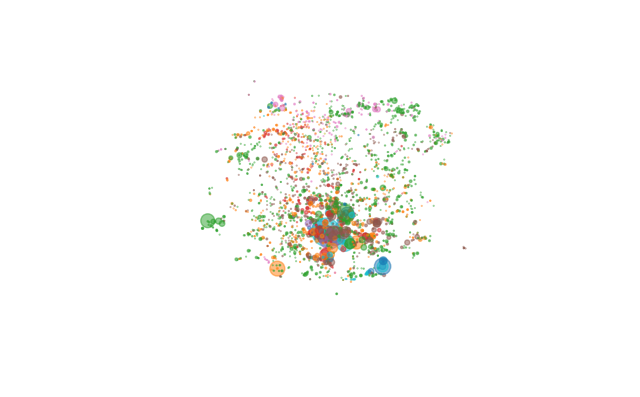

In [12]:
# plt.style.use('dark_background')
fig = plt.figure(figsize=(8, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(V_tsne[:, 0], V_tsne[:, 1], V_tsne[:, 2], c=y, s=s, cmap='tab10', marker='.', alpha=.5)
# ax.scatter(V_tsne[:, 0], V_tsne[:, 1], V_tsne[:, 2], c=y, s=s, cmap='Spectral', marker='.', alpha=.3)
# ax.view_init(20, 20)
ax.axis('off')
fig.show()

Create animation

In [13]:
from multiprocessing import Pool
import io
import cv2

!apt-get update
!apt-get install imagemagick

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://archive.ubuntu.co

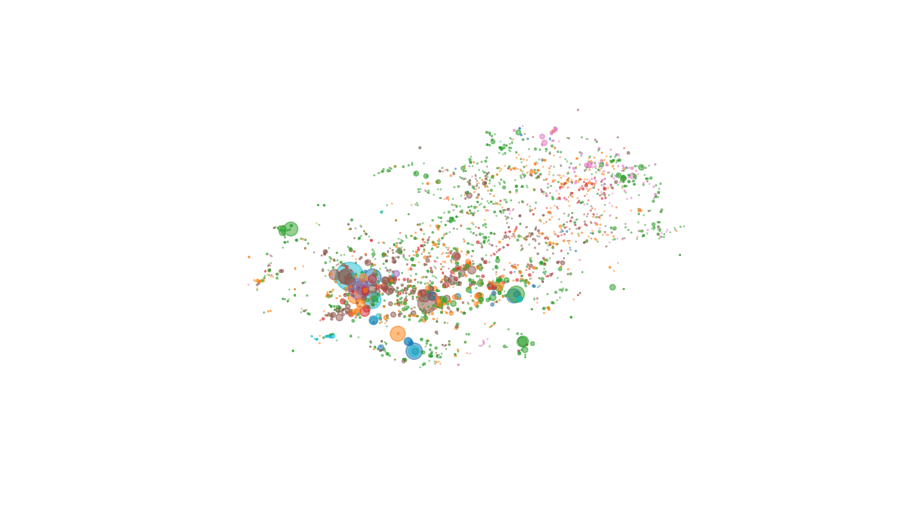

In [14]:
def make_figure(angle):
  fig = plt.figure(figsize=(9, 5), dpi=100)

# plt.style.use('dark_background')
# fig = plt.figure(figsize=(8, 5), dpi=100)

  ax = fig.add_subplot(1, 1, 1, projection='3d')
  # ax.set_facecolor("black")
  # for label, colour in zip(np.unique(t), plt.cm.nipy_spectral(np.linspace(0, 1, len(np.unique(t))))):
  ax.scatter(V_tsne[:, 0], V_tsne[:, 1], V_tsne[:, 2], c=y, s=s, cmap='tab10', marker='.', alpha=.5)
  # for label, colour in zip(np.unique(t), plt.cm.tab10(np.unique(t))):
  #   ax.scatter(mnist_tsne[t==label, 0], mnist_tsne[t==label, 1],
  #              mnist_tsne[t==label, 2], s=30, c=np.vstack(colour).T, 
  #              linewidth=0, alpha=.3, label="%i" % label)
  # ax.legend()
  # steps = 128
  # angle = frame*360/steps
  ax.view_init(20, angle)
  ax.axis('off')
  fig.tight_layout(pad=0)
  return fig

make_figure(10).show()

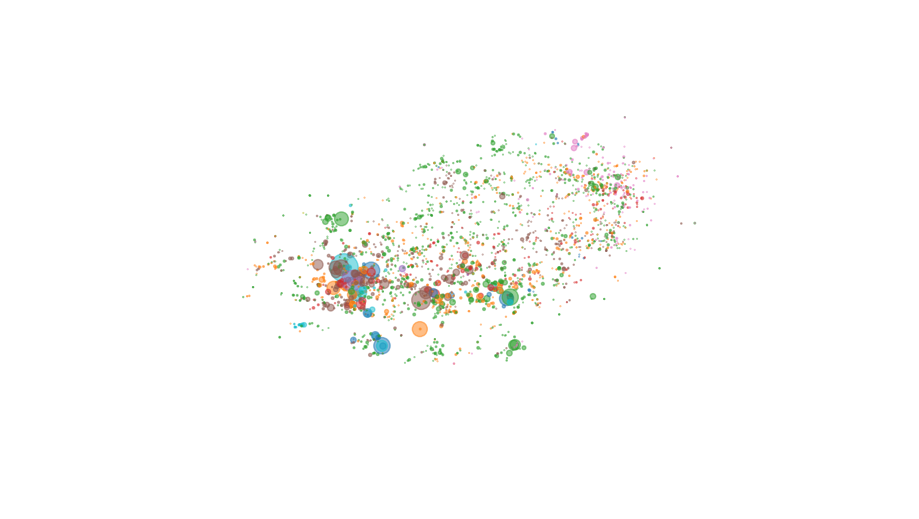

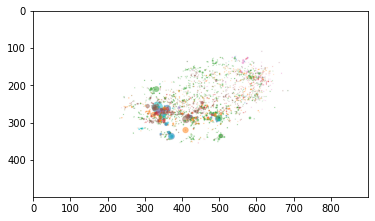

In [15]:
def image_from_figure(fig, dpi=100):
  buffer = io.BytesIO()
  fig.savefig(buffer, format="png", dpi=dpi)
  buffer.seek(0)
  raw = np.frombuffer(buffer.getvalue(), dtype=np.uint8)
  buffer.close()
  image = cv2.imdecode(raw, 1)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

img = image_from_figure(make_figure(30))
plt.figure()
plt.imshow(img)
plt.show()

In [16]:
n_frames = 100

def render_frame(n):
  fig = make_figure(n)
  image = image_from_figure(fig)
  plt.close(fig)
  return image

# Create temporary space
if not os.path.exists("frames"):
  os.mkdir("frames")
else:
  files = ["frames/" + fn for fn in os.listdir("frames") if fn[-3:] == "png"]
  for file in files:
    os.remove(file)

# Render frames
images = list()
with Pool(os.cpu_count()) as pool:
  for i, image in tqdm(enumerate(pool.imap(render_frame, np.linspace(0, 360, n_frames, endpoint=False))),
                         total=n_frames, desc="Rendering frames"):
    images.append(image)

# Global crop
acc = images[0].copy()
for image in images[1:]:
  acc += image
acc = np.sum(acc, axis=2)
projection = np.sum(acc, axis=1)
h1, h2 = np.where(projection<projection.max())[0][[0, -1]]
projection = np.sum(acc, axis=0)
w1, w2 = np.where(projection<projection.max())[0][[0, -1]]
border = 1
images = [image[h1-border:h2+border, w1-border:w2+border, :] for image in images]

# Write images
for n, image in enumerate(images):
  cv2.imwrite("frames/frame%03i.png" % n, image)

Rendering frames: 100%|██████████| 100/100 [00:16<00:00,  6.24it/s]


In [17]:
# height: 146px;
# width: 262px;

!convert -resize 262x146 -delay 10 -loop 0 -depth 6 frames/frame*.png ml_logo.gif
!convert -resize 131x73 -delay 10 -loop 0 frames/frame*.png ml_logo_small.gif
# !convert -resize 131x73 -background "rgb(0,0,0)" -delay 10 -loop 0 frames/frame*.png ml_logo.gif

!convert ml_logo.gif -fuzz 5% -layers Optimize ml_logo_optim.gif
!convert ml_logo_small.gif -fuzz 5% -layers Optimize ml_logo_small_optim.gif

!ls -l

total 2836
drwx------ 5 root root    4096 Feb 10 13:01 drive
drwxr-xr-x 2 root root    4096 Feb 10 13:24 frames
-rw-r--r-- 1 root root 1151410 Feb 10 13:24 ml_logo.gif
-rw-r--r-- 1 root root  994636 Feb 10 13:24 ml_logo_optim.gif
-rw-r--r-- 1 root root  443932 Feb 10 13:24 ml_logo_small.gif
-rw-r--r-- 1 root root  293379 Feb 10 13:24 ml_logo_small_optim.gif
drwxr-xr-x 1 root root    4096 Feb  4 15:26 sample_data


In [18]:
 !identify ml_logo_optim.gif

ml_logo_optim.gif[0] GIF 244x146 244x146+0+0 8-bit sRGB 256c 995KB 0.000u 0:00.010
ml_logo_optim.gif[1] GIF 231x135 244x146+7+2 8-bit sRGB 256c 995KB 0.000u 0:00.010
ml_logo_optim.gif[2] GIF 229x135 244x146+7+2 8-bit sRGB 256c 995KB 0.000u 0:00.010
ml_logo_optim.gif[3] GIF 227x134 244x146+7+3 8-bit sRGB 256c 995KB 0.000u 0:00.010
ml_logo_optim.gif[4] GIF 225x133 244x146+6+3 8-bit sRGB 256c 995KB 0.000u 0:00.010
ml_logo_optim.gif[5] GIF 224x132 244x146+5+4 8-bit sRGB 256c 995KB 0.000u 0:00.010
ml_logo_optim.gif[6] GIF 227x131 244x146+5+4 8-bit sRGB 256c 995KB 0.000u 0:00.010
ml_logo_optim.gif[7] GIF 229x130 244x146+5+5 8-bit sRGB 256c 995KB 0.000u 0:00.010
ml_logo_optim.gif[8] GIF 232x129 244x146+5+6 8-bit sRGB 256c 995KB 0.000u 0:00.010
ml_logo_optim.gif[9] GIF 234x127 244x146+4+7 8-bit sRGB 256c 995KB 0.000u 0:00.010
ml_logo_optim.gif[10] GIF 236x127 244x146+4+7 8-bit sRGB 256c 995KB 0.000u 0:00.010
ml_logo_optim.gif[11] GIF 237x126 244x146+4+8 8-bit sRGB 256c 995KB 0.000u 0:00.010
ml